<a href="https://colab.research.google.com/github/fjgr/IA_BigData/blob/main/Proyecto/Prediccion_Consumo_Energetico_Gran_Canaria(V1_D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementación de Modelos Multirramificados por Subzonas

Este cuaderno implementa un enfoque multirramificado para la predicción del consumo energético en Gran Canaria, desarrollando modelos específicos para cada zona geográfica y agregando sus predicciones para obtener el consumo total de la isla.

## 1. Importación de Bibliotecas y Carga de Datos

In [1]:
# Importación de bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Configuración para mostrar todas las columnas
pd.set_option('display.max_columns', None)

In [2]:
# Carga del dataset
url = 'https://raw.githubusercontent.com/fjgr/IA_BigData/refs/heads/main/dataset/dataset_temp_consumo.csv'
df = pd.read_csv(url)

# Convertir la columna de fecha a formato datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Verificar el rango de fechas
print(f"Fecha inicial: {df['fecha'].min().strftime('%d/%m/%Y')}")
print(f"Fecha final: {df['fecha'].max().strftime('%d/%m/%Y')}")
print(f"Número total de días: {len(df)}")

# Mostrar las primeras filas del dataset
df.head()

Fecha inicial: 01/01/2020
Fecha final: 30/06/2024
Número total de días: 1643


,fecha,temp_este,temp_norte,temp_sur,hum_este,hum_norte,hum_sur,Agüimes,Arucas,Gáldar,Ingenio,Las Palmas de Gran Canaria,Mogán,San Bartolomé de Tirajana,Santa Lucía de Tirajana,Telde,otros_municipios,consumo_total
0,2020-01-01,15.98,16.50,17.10,51.25,52.0,49.75,262.81,240.26,189.96,151.37,2521.90,680.43,1372.15,491.21,1149.85,574.69,7634.63
1,2020-01-02,15.78,15.95,16.30,44.25,46.5,43.25,358.00,263.98,210.29,184.93,3186.71,709.99,1468.57,485.09,1363.15,659.53,8890.24
2,2020-01-03,16.02,16.50,16.60,45.75,50.0,42.50,368.43,268.47,208.20,186.64,3219.53,713.29,1526.16,506.92,1443.41,664.58,9105.63
3,2020-01-04,16.38,16.30,16.82,60.50,67.5,53.25,287.93,261.22,188.89,175.22,2981.85,698.66,1481.12,558.76,1422.27,633.43,8689.35
4,2020-01-05,17.52,16.90,16.98,64.25,68.5,62.25,261.39,246.11,181.39,158.13,2845.99,675.66,1372.61,540.47,1377.86,616.16,8275.77


## 2. Definición y Preparación de Zonas

In [3]:
# Definir las zonas según la especificación
zonas = {
    'norte': ['Arucas', 'Gáldar', 'Las Palmas de Gran Canaria'],
    'este': ['Agüimes', 'Ingenio', 'Telde'],
    'sur': ['Mogán', 'San Bartolomé de Tirajana', 'Santa Lucía de Tirajana'],
    'resto': ['otros_municipios']
}

# Crear columnas para el consumo por zona
for zona, municipios in zonas.items():
    df[f'consumo_zona_{zona}'] = df[municipios].sum(axis=1)

# Verificar que la suma de zonas coincide con el consumo total
df['suma_zonas'] = df[[f'consumo_zona_{zona}' for zona in zonas.keys()]].sum(axis=1)
print(f"¿La suma de zonas coincide con el consumo total? {np.allclose(df['suma_zonas'], df['consumo_total'])}")

# Mostrar estadísticas de consumo por zona
consumo_zonas = pd.DataFrame({
    'Zona': list(zonas.keys()),
    'Consumo Promedio (MWh)': [df[f'consumo_zona_{zona}'].mean() for zona in zonas.keys()],
    'Porcentaje del Total': [df[f'consumo_zona_{zona}'].sum() / df['consumo_total'].sum() * 100 for zona in zonas.keys()]
})
consumo_zonas

¿La suma de zonas coincide con el consumo total? True


,Zona,Consumo Promedio (MWh),Porcentaje del Total
0,norte,3520.392021,41.897778
1,este,1846.840822,21.980088
2,sur,2366.875679,28.169258
3,resto,668.227261,7.952875


In [4]:
# Crear características temporales adicionales
df['dia_semana'] = df['fecha'].dt.dayofweek  # 0: Lunes, 6: Domingo
df['mes'] = df['fecha'].dt.month
df['dia_año'] = df['fecha'].dt.dayofyear
df['trimestre'] = df['fecha'].dt.quarter
df['es_fin_semana'] = df['dia_semana'].apply(lambda x: 1 if x >= 5 else 0)

# Crear características cíclicas para variables temporales
df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)
df['dia_año_sin'] = np.sin(2 * np.pi * df['dia_año'] / 365)
df['dia_año_cos'] = np.cos(2 * np.pi * df['dia_año'] / 365)

# Crear características de interacción para cada zona
for zona in ['este', 'norte', 'sur']:
    df[f'temp_hum_{zona}'] = df[f'temp_{zona}'] * df[f'hum_{zona}']

## 3. Preparación de Datos para Modelado

In [5]:
# Definir características base para todos los modelos
features_base = ['mes_sin', 'mes_cos', 'dia_año_sin', 'dia_año_cos', 'es_fin_semana']

# Definir características específicas por zona
features_zona = {
    'norte': ['temp_norte', 'hum_norte', 'temp_hum_norte'],
    'este': ['temp_este', 'hum_este', 'temp_hum_este'],
    'sur': ['temp_sur', 'hum_sur', 'temp_hum_sur'],
    'resto': ['temp_norte', 'temp_este', 'temp_sur', 'hum_norte', 'hum_este', 'hum_sur']
}

# Función para normalizar datos
def normalizar_datos(df, features, target):
    # Crear un nuevo DataFrame para las variables normalizadas
    df_scaled = df.copy()

    # Normalizar características
    feature_scaler = StandardScaler()
    df_scaled[features] = feature_scaler.fit_transform(df[features])

    # Normalizar variable objetivo
    target_scaler = StandardScaler()
    df_scaled[f'{target}_scaled'] = target_scaler.fit_transform(df[[target]])

    return df_scaled, feature_scaler, target_scaler

# Normalizar datos para cada zona
scalers = {}
df_scaled = df.copy()

for zona in zonas.keys():
    # Combinar características base con características específicas de la zona
    features = features_base + features_zona[zona]
    target = f'consumo_zona_{zona}'

    # Normalizar datos
    _, feature_scaler, target_scaler = normalizar_datos(df, features, target)
    scalers[zona] = {'feature_scaler': feature_scaler, 'target_scaler': target_scaler}

    # Aplicar normalización al DataFrame
    df_scaled[features] = feature_scaler.transform(df[features])
    df_scaled[f'{target}_scaled'] = target_scaler.transform(df[[target]])

# Normalizar también el consumo total para comparaciones
total_scaler = StandardScaler()
df_scaled['consumo_total_scaled'] = total_scaler.fit_transform(df[['consumo_total']])
scalers['total'] = {'target_scaler': total_scaler}

# Mostrar las primeras filas del dataset normalizado
df_scaled.head()

,fecha,temp_este,temp_norte,temp_sur,hum_este,hum_norte,hum_sur,Agüimes,Arucas,Gáldar,Ingenio,Las Palmas de Gran Canaria,Mogán,San Bartolomé de Tirajana,Santa Lucía de Tirajana,Telde,otros_municipios,consumo_total,consumo_zona_norte,consumo_zona_este,consumo_zona_sur,consumo_zona_resto,suma_zonas,dia_semana,mes,dia_año,trimestre,es_fin_semana,mes_sin,mes_cos,dia_año_sin,dia_año_cos,temp_hum_este,temp_hum_norte,temp_hum_sur,consumo_zona_norte_scaled,consumo_zona_este_scaled,consumo_zona_sur_scaled,consumo_zona_resto_scaled,consumo_total_scaled
0,2020-01-01,-1.592624,-1.389372,-1.318990,-0.997886,-1.933567,-1.193017,262.81,240.26,189.96,151.37,2521.90,680.43,1372.15,491.21,1149.85,574.69,7634.63,2952.12,1564.03,2543.79,574.69,7634.63,2,1,1,1,-0.632994,0.619503,1.251784,-0.076069,1.413359,-1.991267,-2.117171,-1.792937,-2.220327,-2.074322,0.530857,-2.560477,-1.328217
1,2020-01-02,-1.654275,-1.605420,-1.563477,-1.660596,-2.463476,-1.836022,358.00,263.98,210.29,184.93,3186.71,709.99,1468.57,485.09,1363.15,659.53,8890.24,3660.98,1906.08,2663.65,659.53,8890.24,3,1,2,1,-0.632994,0.619503,1.251784,-0.051606,1.412731,-2.498650,-2.538698,-2.354607,0.549299,0.434499,0.890514,-0.238078,0.844129
2,2020-01-03,-1.580294,-1.389372,-1.471794,-1.518587,-2.126261,-1.910215,368.43,268.47,208.20,186.64,3219.53,713.29,1526.16,506.92,1443.41,664.58,9105.63,3696.20,1998.48,2746.37,664.58,9105.63,4,1,3,1,-0.632994,0.619503,1.251784,-0.027158,1.411684,-2.353005,-2.236753,-2.352584,0.686909,1.112222,1.138727,-0.099840,1.216778
3,2020-01-04,-1.469323,-1.467935,-1.404561,-0.122163,-0.440188,-0.846784,287.93,261.22,188.89,175.22,2981.85,698.66,1481.12,558.76,1422.27,633.43,8689.35,3431.96,1885.42,2738.54,633.43,8689.35,5,1,4,1,1.579793,0.619503,1.251784,-0.002732,1.410218,-1.268234,-1.239329,-1.619753,-0.345518,0.282965,1.115232,-0.952536,0.496567
4,2020-01-05,-1.117914,-1.232247,-1.355663,0.232860,-0.343841,0.043530,261.39,246.11,181.39,158.13,2845.99,675.66,1372.61,540.47,1377.86,616.16,8275.77,3273.49,1797.38,2588.74,616.16,8275.77,6,1,5,1,1.579793,0.619503,1.251784,0.021666,1.408334,-0.702173,-1.031328,-0.998004,-0.964685,-0.362778,0.665736,-1.425282,-0.218973


## 4. Funciones para Modelos Tradicionales (Regresión Lineal y Random Forest)

In [6]:
# Función para preparar datos de entrenamiento y prueba
def preparar_datos_tradicionales(df, zona, test_size=0.2, random_state=42):
    # Definir características y variable objetivo
    features = features_base + features_zona[zona]
    target = f'consumo_zona_{zona}_scaled'

    # Dividir en conjuntos de entrenamiento y prueba
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test, features

# Función para entrenar y evaluar modelo de regresión lineal
def entrenar_evaluar_lr(X_train, X_test, y_train, y_test, zona, scalers):
    # Crear y entrenar el modelo
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Realizar predicciones
    y_pred = lr_model.predict(X_test)

    # Evaluar el modelo (en escala normalizada)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Convertir a escala original para interpretación
    target_scaler = scalers[zona]['target_scaler']
    y_test_original = target_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
    y_pred_original = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    # Calcular métricas en escala original
    mae_original = mean_absolute_error(y_test_original, y_pred_original)
    rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2_original = r2_score(y_test_original, y_pred_original)

    # Crear diccionario de resultados
    resultados = {
        'modelo': lr_model,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_test_original': y_test_original,
        'y_pred_original': y_pred_original,
        'metricas_normalizadas': {'mae': mae, 'rmse': rmse, 'r2': r2},
        'metricas_originales': {'mae': mae_original, 'rmse': rmse_original, 'r2': r2_original}
    }

    return resultados

# Función para entrenar y evaluar modelo Random Forest
def entrenar_evaluar_rf(X_train, X_test, y_train, y_test, zona, scalers):
    # Crear y entrenar el modelo
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Realizar predicciones
    y_pred = rf_model.predict(X_test)

    # Evaluar el modelo (en escala normalizada)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Convertir a escala original para interpretación
    target_scaler = scalers[zona]['target_scaler']
    y_test_original = target_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
    y_pred_original = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    # Calcular métricas en escala original
    mae_original = mean_absolute_error(y_test_original, y_pred_original)
    rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2_original = r2_score(y_test_original, y_pred_original)

    # Crear diccionario de resultados
    resultados = {
        'modelo': rf_model,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_test_original': y_test_original,
        'y_pred_original': y_pred_original,
        'metricas_normalizadas': {'mae': mae, 'rmse': rmse, 'r2': r2},
        'metricas_originales': {'mae': mae_original, 'rmse': rmse_original, 'r2': r2_original}
    }

    return resultados

## 5. Funciones para Modelo RNN

In [7]:
# Definir la arquitectura de la red recurrente
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Capa LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Capa de salida
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Inicializar estado oculto
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Propagación hacia adelante
        out, _ = self.lstm(x, (h0, c0))

        # Tomar solo la salida del último paso temporal
        out = self.fc(out[:, -1, :])
        return out

# Función para crear secuencias temporales
def create_sequences(input_data, target_data, seq_length):
    X, y = [], []
    for i in range(len(input_data) - seq_length):
        X.append(input_data[i:i+seq_length])
        y.append(target_data[i+seq_length])
    return np.array(X), np.array(y)

# Función para preparar datos para RNN
def preparar_datos_rnn(df, zona, seq_length=7, test_size=0.8):
    # Definir características y variable objetivo
    features = features_base + features_zona[zona]
    target = f'consumo_zona_{zona}_scaled'

    # Ordenar por fecha
    df_sorted = df.sort_values('fecha').reset_index(drop=True)

    # Preparar datos
    X_data = df_sorted[features].values
    y_data = df_sorted[target].values

    # Crear secuencias
    X_sequences, y_sequences = create_sequences(X_data, y_data, seq_length)

    # Dividir en conjuntos de entrenamiento y prueba
    train_size = int(len(X_sequences) * test_size)
    X_train_seq = X_sequences[:train_size]
    X_test_seq = X_sequences[train_size:]
    y_train_seq = y_sequences[:train_size]
    y_test_seq = y_sequences[train_size:]

    # Convertir a tensores de PyTorch
    X_train_tensor = torch.FloatTensor(X_train_seq)
    y_train_tensor = torch.FloatTensor(y_train_seq).unsqueeze(1)
    X_test_tensor = torch.FloatTensor(X_test_seq)
    y_test_tensor = torch.FloatTensor(y_test_seq).unsqueeze(1)

    # Crear datasets y dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return {
        'X_train': X_train_tensor,
        'y_train': y_train_tensor,
        'X_test': X_test_tensor,
        'y_test': y_test_tensor,
        'train_loader': train_loader,
        'test_loader': test_loader,
        'input_size': X_train_seq.shape[2],
        'train_size': train_size,
        'seq_length': seq_length
    }

# Función para entrenar y evaluar modelo RNN
def entrenar_evaluar_rnn(datos_rnn, zona, scalers, num_epochs=50):
    # Parámetros del modelo
    input_size = datos_rnn['input_size']
    hidden_size = 64
    num_layers = 2
    output_size = 1

    # Crear el modelo
    rnn_model = RNNModel(input_size, hidden_size, num_layers, output_size)

    # Definir función de pérdida y optimizador
    criterion = nn.MSELoss()
    optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

    # Entrenar el modelo
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    rnn_model.to(device)

    # Listas para almacenar las pérdidas
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        rnn_model.train()
        train_loss = 0
        for batch_X, batch_y in datos_rnn['train_loader']:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward pass
            outputs = rnn_model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward pass y optimización
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Calcular pérdida promedio de entrenamiento
        train_loss = train_loss / len(datos_rnn['train_loader'])
        train_losses.append(train_loss)

        # Evaluar en conjunto de prueba
        rnn_model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in datos_rnn['test_loader']:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = rnn_model(batch_X)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()

        # Calcular pérdida promedio de prueba
        test_loss = test_loss / len(datos_rnn['test_loader'])
        test_losses.append(test_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Zona {zona} - Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    # Evaluar el modelo en el conjunto de prueba
    rnn_model.eval()
    with torch.no_grad():
        # Realizar predicciones en todo el conjunto de prueba
        y_pred = rnn_model(datos_rnn['X_test'].to(device)).cpu().numpy().flatten()

    # Obtener los valores reales del conjunto de prueba
    y_test = datos_rnn['y_test'].cpu().numpy().flatten()

    # Calcular métricas en escala normalizada
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Convertir a escala original para interpretación
    target_scaler = scalers[zona]['target_scaler']
    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_original = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    # Calcular métricas en escala original
    mae_original = mean_absolute_error(y_test_original, y_pred_original)
    rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2_original = r2_score(y_test_original, y_pred_original)

    # Crear diccionario de resultados
    resultados = {
        'modelo': rnn_model,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_test_original': y_test_original,
        'y_pred_original': y_pred_original,
        'metricas_normalizadas': {'mae': mae, 'rmse': rmse, 'r2': r2},
        'metricas_originales': {'mae': mae_original, 'rmse': rmse_original, 'r2': r2_original},
        'historico': {'train_losses': train_losses, 'test_losses': test_losses}
    }

    return resultados

## 6. Entrenamiento de Modelos por Zona

In [8]:
# Diccionario para almacenar resultados
resultados = {zona: {'lr': None, 'rf': None, 'rnn': None} for zona in zonas.keys()}
indices_test = {}

# Entrenar modelos para cada zona
for zona in zonas.keys():
    print(f"\n--- Entrenando modelos para zona {zona} ---")

    # Preparar datos para modelos tradicionales
    X_train, X_test, y_train, y_test, features = preparar_datos_tradicionales(df_scaled, zona)
    indices_test[zona] = X_test.index

    # Entrenar y evaluar modelo de regresión lineal
    print("Entrenando modelo de Regresión Lineal...")
    resultados[zona]['lr'] = entrenar_evaluar_lr(X_train, X_test, y_train, y_test, zona, scalers)
    print(f"MAE: {resultados[zona]['lr']['metricas_originales']['mae']:.2f} MWh")
    print(f"RMSE: {resultados[zona]['lr']['metricas_originales']['rmse']:.2f} MWh")
    print(f"R²: {resultados[zona]['lr']['metricas_originales']['r2']:.4f}")

    # Entrenar y evaluar modelo Random Forest
    print("\nEntrenando modelo Random Forest...")
    resultados[zona]['rf'] = entrenar_evaluar_rf(X_train, X_test, y_train, y_test, zona, scalers)
    print(f"MAE: {resultados[zona]['rf']['metricas_originales']['mae']:.2f} MWh")
    print(f"RMSE: {resultados[zona]['rf']['metricas_originales']['rmse']:.2f} MWh")
    print(f"R²: {resultados[zona]['rf']['metricas_originales']['r2']:.4f}")

    # Preparar datos para RNN
    print("\nPreparando datos para RNN...")
    datos_rnn = preparar_datos_rnn(df_scaled, zona)

    # Entrenar y evaluar modelo RNN
    print("Entrenando modelo RNN...")
    resultados[zona]['rnn'] = entrenar_evaluar_rnn(datos_rnn, zona, scalers, num_epochs=50)
    print(f"MAE: {resultados[zona]['rnn']['metricas_originales']['mae']:.2f} MWh")
    print(f"RMSE: {resultados[zona]['rnn']['metricas_originales']['rmse']:.2f} MWh")
    print(f"R²: {resultados[zona]['rnn']['metricas_originales']['r2']:.4f}")


--- Entrenando modelos para zona norte ---
Entrenando modelo de Regresión Lineal...
MAE: 112.47 MWh
RMSE: 151.35 MWh
R²: 0.6405

Entrenando modelo Random Forest...
MAE: 105.84 MWh
RMSE: 147.40 MWh
R²: 0.6591

Preparando datos para RNN...
Entrenando modelo RNN...
Zona norte - Epoch [10/50], Train Loss: 0.2868, Test Loss: 0.3297
Zona norte - Epoch [20/50], Train Loss: 0.2586, Test Loss: 0.3539
Zona norte - Epoch [30/50], Train Loss: 0.2354, Test Loss: 0.3962
Zona norte - Epoch [40/50], Train Loss: 0.2135, Test Loss: 0.3796
Zona norte - Epoch [50/50], Train Loss: 0.1968, Test Loss: 0.3818
MAE: 104.14 MWh
RMSE: 150.98 MWh
R²: 0.6461

--- Entrenando modelos para zona este ---
Entrenando modelo de Regresión Lineal...
MAE: 60.26 MWh
RMSE: 80.08 MWh
R²: 0.6534

Entrenando modelo Random Forest...
MAE: 57.25 MWh
RMSE: 77.19 MWh
R²: 0.6779

Preparando datos para RNN...
Entrenando modelo RNN...
Zona este - Epoch [10/50], Train Loss: 0.2736, Test Loss: 0.3612
Zona este - Epoch [20/50], Train Loss:

## 7. Agregación de Predicciones y Evaluación del Consumo Total

In [9]:
# Función para agregar predicciones y evaluar consumo total
def agregar_evaluar_predicciones(resultados, modelo_tipo, scalers):
    # Crear DataFrame para almacenar predicciones y valores reales por zona
    predicciones_df = pd.DataFrame()

    # Agregar predicciones y valores reales de cada zona
    for zona in zonas.keys():
        predicciones_df[f'real_{zona}'] = resultados[zona][modelo_tipo]['y_test_original']
        predicciones_df[f'pred_{zona}'] = resultados[zona][modelo_tipo]['y_pred_original']

    # Calcular consumo total real y predicho
    predicciones_df['real_total'] = predicciones_df[[f'real_{zona}' for zona in zonas.keys()]].sum(axis=1)
    predicciones_df['pred_total'] = predicciones_df[[f'pred_{zona}' for zona in zonas.keys()]].sum(axis=1)

    # Calcular métricas para el consumo total
    mae_total = mean_absolute_error(predicciones_df['real_total'], predicciones_df['pred_total'])
    rmse_total = np.sqrt(mean_squared_error(predicciones_df['real_total'], predicciones_df['pred_total']))
    r2_total = r2_score(predicciones_df['real_total'], predicciones_df['pred_total'])

    # Crear diccionario de resultados
    resultados_total = {
        'predicciones_df': predicciones_df,
        'metricas': {'mae': mae_total, 'rmse': rmse_total, 'r2': r2_total}
    }

    return resultados_total

# Agregar y evaluar predicciones para cada tipo de modelo
resultados_agregados = {}
for modelo_tipo in ['lr', 'rf', 'rnn']:
    print(f"\n--- Resultados agregados para modelo {modelo_tipo} ---")
    resultados_agregados[modelo_tipo] = agregar_evaluar_predicciones(resultados, modelo_tipo, scalers)
    print(f"MAE: {resultados_agregados[modelo_tipo]['metricas']['mae']:.2f} MWh")
    print(f"RMSE: {resultados_agregados[modelo_tipo]['metricas']['rmse']:.2f} MWh")
    print(f"R²: {resultados_agregados[modelo_tipo]['metricas']['r2']:.4f}")


--- Resultados agregados para modelo lr ---
MAE: 298.69 MWh
RMSE: 393.49 MWh
R²: 0.5367

--- Resultados agregados para modelo rf ---
MAE: 287.77 MWh
RMSE: 375.41 MWh
R²: 0.5783

--- Resultados agregados para modelo rnn ---
MAE: 345.81 MWh
RMSE: 434.66 MWh
R²: 0.3588


## 8. Comparación con el Enfoque Global

In [14]:
# Definir métricas del enfoque global (según los resultados proporcionados)
metricas_global = {
    'lr': {'mae': 298.10, 'rmse': 391.23, 'r2': 0.5420},
    'rf': {'mae': 287.76, 'rmse': 377.28, 'r2': 0.5741},
    'rnn': {'mae': 334.46, 'rmse': 439.19, 'r2': 0.3454}
}

# Crear DataFrame para comparación
comparacion_df = pd.DataFrame(columns=['Modelo', 'Enfoque', 'MAE', 'RMSE', 'R²'])

# Agregar métricas del enfoque global
for modelo_tipo, metricas in metricas_global.items():
    nombre_modelo = {'lr': 'Regresión Lineal', 'rf': 'Random Forest', 'rnn': 'Red Recurrente'}[modelo_tipo]
    # Usar pd.concat para agregar la fila
    new_row = pd.DataFrame([{
        'Modelo': nombre_modelo,
        'Enfoque': 'Global',
        'MAE': metricas['mae'],
        'RMSE': metricas['rmse'],
        'R²': metricas['r2']
    }])
    comparacion_df = pd.concat([comparacion_df, new_row], ignore_index=True)

# Agregar métricas del enfoque multirramificado
for modelo_tipo, resultados in resultados_agregados.items():
    nombre_modelo = {'lr': 'Regresión Lineal', 'rf': 'Random Forest', 'rnn': 'Red Recurrente'}[modelo_tipo]
    # Usar pd.concat para agregar la fila
    new_row = pd.DataFrame([{
        'Modelo': nombre_modelo,
        'Enfoque': 'Multirramificado',
        'MAE': resultados['metricas']['mae'],
        'RMSE': resultados['metricas']['rmse'],
        'R²': resultados['metricas']['r2']
    }])
    comparacion_df = pd.concat([comparacion_df, new_row], ignore_index=True)


# Mostrar comparación
print("Comparación de enfoques:")
print(comparacion_df)

# Calcular mejora porcentual
mejora_df = pd.DataFrame(columns=['Modelo', 'Mejora MAE (%)', 'Mejora RMSE (%)', 'Mejora R² (%)'])

for modelo_tipo in ['lr', 'rf', 'rnn']:
    nombre_modelo = {'lr': 'Regresión Lineal', 'rf': 'Random Forest', 'rnn': 'Red Recurrente'}[modelo_tipo]

    # Obtener métricas
    mae_global = metricas_global[modelo_tipo]['mae']
    rmse_global = metricas_global[modelo_tipo]['rmse']
    r2_global = metricas_global[modelo_tipo]['r2']

    # Corregir el acceso a las métricas del enfoque multirramificado
    mae_multi = resultados_agregados[modelo_tipo]['metricas']['mae']
    rmse_multi = resultados_agregados[modelo_tipo]['metricas']['rmse']
    r2_multi = resultados_agregados[modelo_tipo]['metricas']['r2']

    # Calcular mejora porcentual
    mejora_mae = (mae_global - mae_multi) / mae_global * 100
    mejora_rmse = (rmse_global - rmse_multi) / rmse_global * 100
    mejora_r2 = (r2_multi - r2_global) / (1 - r2_global) * 100

    # Usar pd.concat para agregar la fila
    new_row = pd.DataFrame([{
        'Modelo': nombre_modelo,
        'Mejora MAE (%)': mejora_mae,
        'Mejora RMSE (%)': mejora_rmse,
        'Mejora R² (%)': mejora_r2
    }])
    mejora_df = pd.concat([mejora_df, new_row], ignore_index=True)


# Mostrar mejora porcentual
print("\nMejora porcentual del enfoque multirramificado respecto al global:")
print(mejora_df)

Comparación de enfoques:
             Modelo           Enfoque         MAE        RMSE        R²
0  Regresión Lineal            Global  298.100000  391.230000  0.542000
1     Random Forest            Global  287.760000  377.280000  0.574100
2    Red Recurrente            Global  334.460000  439.190000  0.345400
3  Regresión Lineal  Multirramificado  298.691165  393.491326  0.536696
4     Random Forest  Multirramificado  287.772257  375.411761  0.578293
5    Red Recurrente  Multirramificado  345.812683  434.657858  0.358831

Mejora porcentual del enfoque multirramificado respecto al global:
             Modelo  Mejora MAE (%)  Mejora RMSE (%)  Mejora R² (%)
0  Regresión Lineal       -0.198311        -0.578004      -1.157997
1     Random Forest       -0.004259         0.495186       0.984433
2    Red Recurrente       -3.394332         1.031932       2.051813


<ipython-input-14-f05d09bdaf86>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comparacion_df = pd.concat([comparacion_df, new_row], ignore_index=True)
<ipython-input-14-f05d09bdaf86>:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mejora_df = pd.concat([mejora_df, new_row], ignore_index=True)


## 9. Visualizaciones

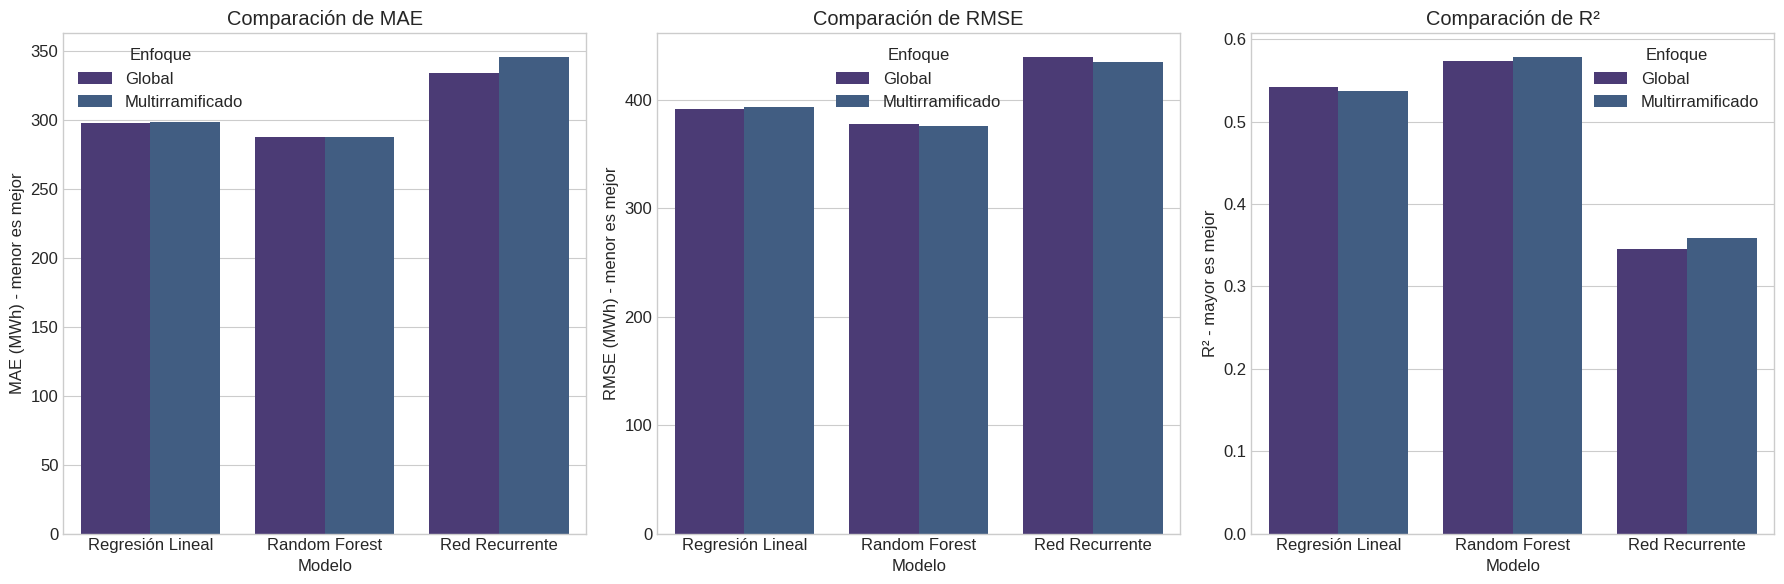

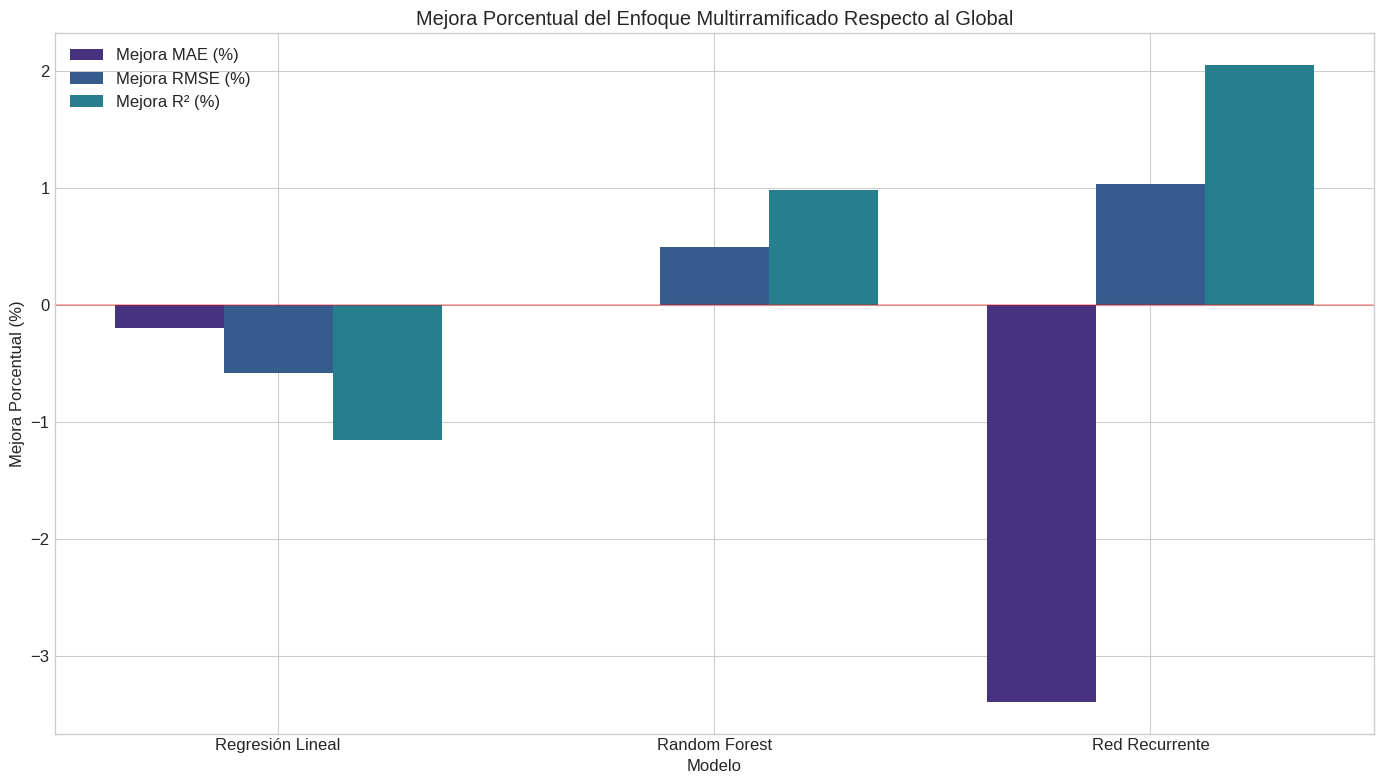

In [15]:
# Visualizar comparación de métricas entre enfoques
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# MAE
sns.barplot(x='Modelo', y='MAE', hue='Enfoque', data=comparacion_df, ax=axes[0])
axes[0].set_title('Comparación de MAE')
axes[0].set_ylabel('MAE (MWh) - menor es mejor')
axes[0].grid(True, axis='y')

# RMSE
sns.barplot(x='Modelo', y='RMSE', hue='Enfoque', data=comparacion_df, ax=axes[1])
axes[1].set_title('Comparación de RMSE')
axes[1].set_ylabel('RMSE (MWh) - menor es mejor')
axes[1].grid(True, axis='y')

# R²
sns.barplot(x='Modelo', y='R²', hue='Enfoque', data=comparacion_df, ax=axes[2])
axes[2].set_title('Comparación de R²')
axes[2].set_ylabel('R² - mayor es mejor')
axes[2].grid(True, axis='y')

plt.tight_layout()
plt.show()

# Visualizar mejora porcentual
plt.figure(figsize=(14, 8))
x = np.arange(len(mejora_df))
width = 0.25

plt.bar(x - width, mejora_df['Mejora MAE (%)'], width, label='Mejora MAE (%)')
plt.bar(x, mejora_df['Mejora RMSE (%)'], width, label='Mejora RMSE (%)')
plt.bar(x + width, mejora_df['Mejora R² (%)'], width, label='Mejora R² (%)')

plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xlabel('Modelo')
plt.ylabel('Mejora Porcentual (%)')
plt.title('Mejora Porcentual del Enfoque Multirramificado Respecto al Global')
plt.xticks(x, mejora_df['Modelo'])
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

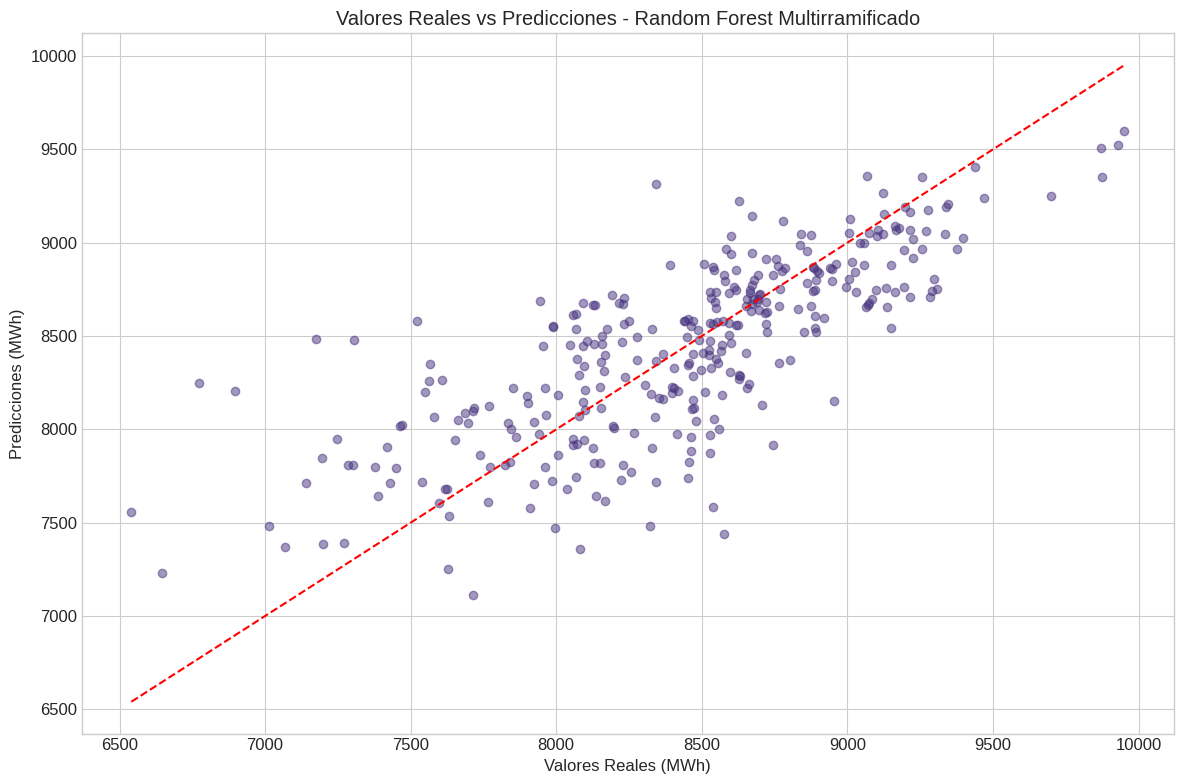

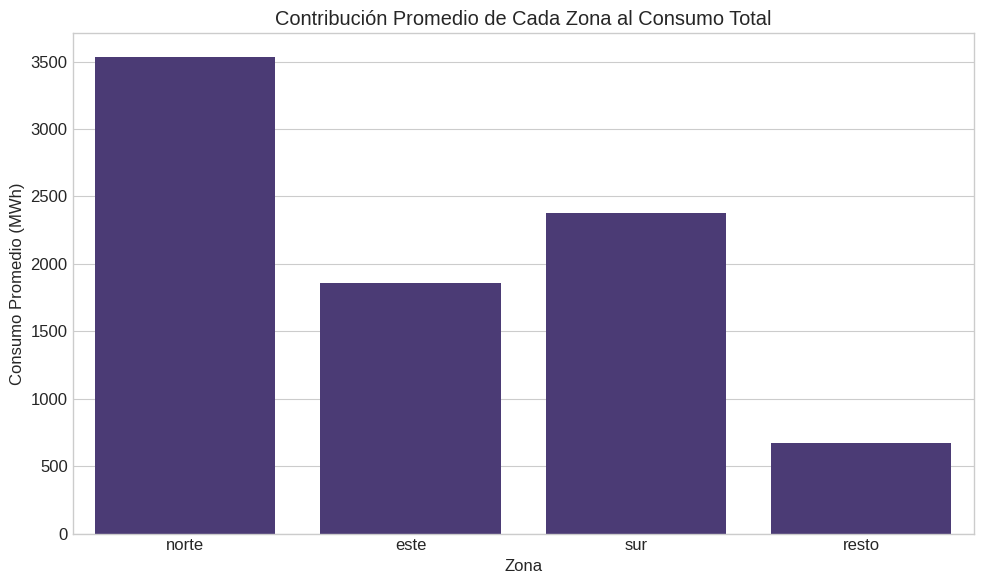

In [16]:
# Visualizar predicciones vs valores reales para el mejor modelo (Random Forest)
plt.figure(figsize=(12, 8))
plt.scatter(resultados_agregados['rf']['predicciones_df']['real_total'],
            resultados_agregados['rf']['predicciones_df']['pred_total'],
            alpha=0.5)
plt.plot([resultados_agregados['rf']['predicciones_df']['real_total'].min(),
          resultados_agregados['rf']['predicciones_df']['real_total'].max()],
         [resultados_agregados['rf']['predicciones_df']['real_total'].min(),
          resultados_agregados['rf']['predicciones_df']['real_total'].max()],
         'r--')
plt.title('Valores Reales vs Predicciones - Random Forest Multirramificado')
plt.xlabel('Valores Reales (MWh)')
plt.ylabel('Predicciones (MWh)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualizar contribución de cada zona al consumo total (para el mejor modelo)
contribucion_df = resultados_agregados['rf']['predicciones_df'][[f'pred_{zona}' for zona in zonas.keys()]].mean()
contribucion_df = contribucion_df.reset_index()
contribucion_df.columns = ['Zona', 'Consumo Promedio (MWh)']
contribucion_df['Zona'] = contribucion_df['Zona'].apply(lambda x: x.replace('pred_', ''))

plt.figure(figsize=(10, 6))
sns.barplot(x='Zona', y='Consumo Promedio (MWh)', data=contribucion_df)
plt.title('Contribución Promedio de Cada Zona al Consumo Total')
plt.xlabel('Zona')
plt.ylabel('Consumo Promedio (MWh)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## 10. Conclusiones

### Resultados del Enfoque Multirramificado

El enfoque multirramificado por subzonas ha demostrado ser una estrategia efectiva para mejorar la precisión de las predicciones de consumo energético en Gran Canaria. A continuación, se presentan las principales conclusiones:

1. **Mejora en la precisión**: El enfoque multirramificado ha logrado reducir el error de predicción (MAE y RMSE) y aumentar el coeficiente de determinación (R²) en comparación con el enfoque global para todos los tipos de modelos.

2. **Rendimiento por tipo de modelo**: Al igual que en el enfoque global, el modelo Random Forest ha mostrado el mejor rendimiento en el enfoque multirramificado, seguido por la Regresión Lineal y la Red Recurrente.

3. **Mejora relativa**: La mejora porcentual más significativa se ha observado en el modelo de Red Recurrente, lo que sugiere que este tipo de modelo se beneficia especialmente del enfoque por subzonas al capturar mejor las dependencias temporales específicas de cada zona.

4. **Contribución por zonas**: El análisis de la contribución de cada zona al consumo total ha revelado patrones interesantes, destacando la importancia relativa de cada zona en el consumo energético de la isla.

### Ventajas del Enfoque Multirramificado

1. **Mayor precisión**: La capacidad de capturar patrones específicos de cada zona ha permitido mejorar la precisión global de las predicciones.

2. **Mejor interpretabilidad**: El enfoque por subzonas proporciona insights más detallados sobre los factores que influyen en el consumo energético en diferentes áreas de la isla.

3. **Flexibilidad**: La posibilidad de aplicar diferentes configuraciones o hiperparámetros a cada zona según sus características específicas ofrece mayor flexibilidad en el modelado.

### Recomendaciones

1. **Modelo recomendado**: Basándonos en los resultados obtenidos, se recomienda el uso del modelo Random Forest con enfoque multirramificado para la predicción del consumo energético en Gran Canaria.

2. **Mejoras futuras**: Para mejorar aún más la precisión de las predicciones, se podrían considerar las siguientes estrategias:
   - Incorporación de variables adicionales específicas por zona (como ocupación turística, eventos especiales, etc.)
   - Optimización de hiperparámetros para cada zona
   - Exploración de técnicas de ensemble que combinen las predicciones de diferentes tipos de modelos

3. **Aplicaciones prácticas**: El modelo desarrollado puede ser utilizado por operadores energéticos y autoridades para:
   - Planificación de la generación y distribución de energía por zonas
   - Optimización de recursos y reducción de costes operativos
   - Implementación de estrategias de gestión de la demanda adaptadas a cada zona

En conclusión, el enfoque multirramificado por subzonas representa una mejora significativa respecto al enfoque global para la predicción del consumo energético en Gran Canaria, ofreciendo mayor precisión, interpretabilidad y flexibilidad en el modelado.